# QPSK Demodulation Using LSTM Seq2Seq Autoencoder

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import *

## Define baseline

What are we trying to accomplish? QPSK demodulation

In [2]:
samples, _ = generate_qpsk(100)
hrrc = make_rrc(num_weights=65, fs=4)
samples = pulse_shape(samples, hrrc, sps=4)
# fix, ax = plt.subplots(1,2,figsize=(10,4))

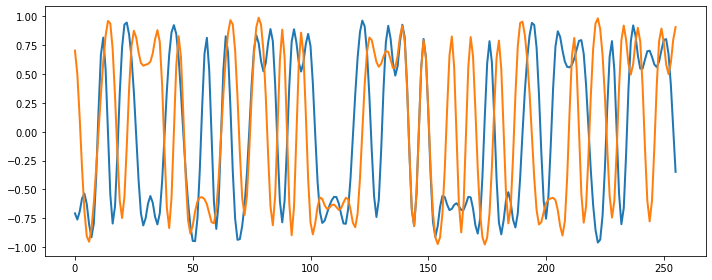

In [3]:
plt.figure(figsize=(10,4))
plt.plot(samples.real[:256], linewidth=2); plt.plot(samples.imag[:256], linewidth=2)
# ax[1].plot(samples.real, samples.imag, 'o')
# ax[1].grid()
plt.tight_layout()
plt.savefig('temp.svg', dpi=300)

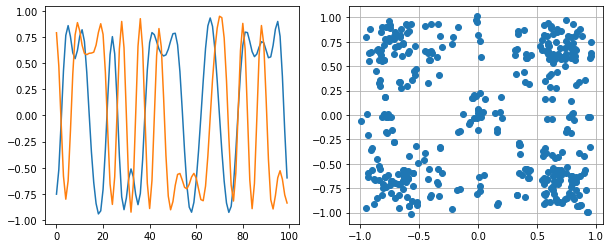

In [4]:
samples, _ = generate_qpsk(100)
hrrc = make_rrc(num_weights=65, fs=4)
samples = pulse_shape(samples, hrrc, sps=4)
fix, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(samples.real[:100]); ax[0].plot(samples.imag[:100])
ax[1].plot(samples.real, samples.imag, 'o')
ax[1].grid()

In [5]:
# simple function for qpsk demodulation
def receive_decimate(noisy_symbols, hrrc, sps=8):
    
    symbol_dict = {(1, 1): 0,
               (1, 0): 1,
               (0, 1): 2,
               (0, 0): 3}

    syms_filtered = np.convolve(noisy_symbols, hrrc, mode='same')
    extract_symbols = syms_filtered[np.arange(0,len(noisy_symbols),sps)]
    extract_symbols.real = np.where(extract_symbols.real >= 0.5, 1, 0)
    extract_symbols.imag = np.where(extract_symbols.imag >= 0.5, 1, 0)

    return np.array([symbol_dict[(int(symbol.real),int(symbol.imag))] for symbol in extract_symbols])

Sanity check if my python functions are equivalent to what matlab produces...

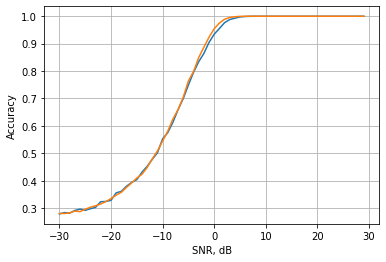

In [6]:
import scipy.io as sio
matlab_data = sio.loadmat('matlab_accs.mat')

sps=4
span=10
num_weights= sps*span+1
hrrc = make_rrc(num_weights=num_weights, fs=sps, alpha=0.35)

snr_range = np.arange(-30,30)
baseline_accs = []
for snr in snr_range:
    syms, ints = generate_qpsk(10000)
    syms_shaped = pulse_shape(syms, hrrc, sps=sps)
    syms_shaped = awgn(syms_shaped, snr, measured=True)
    y_baseline = receive_decimate(syms_shaped, hrrc, sps=sps)
    baseline_accs.append(sum(y_baseline == ints)/(len(syms)))

plt.plot(snr_range, baseline_accs)
plt.plot(snr_range, matlab_data['accs'][0,:])
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.grid()

## Generate training data

We will need pairs of sequences of pulse shaped symbols and labels. 

In [7]:
def gen_data(num_examples, seq_length, sps=4, span=10, snr=50, normalize=True, append_eos=False):
    '''
    This function produces a num_examples number of pulse shaped QPSK waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate the QPSK symbols
    qpsk_symbols, bits = generate_qpsk(num_examples * seq_length)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    qpsk_symbols_shaped = awgn(pulse_shape(qpsk_symbols, hrrc, sps=sps), snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = qpsk_symbols_shaped.reshape(num_examples,-1)
    labels = bits.reshape(num_examples,-1)
    
    # Optionally append an EOS token to the end of the label of each sequence
    if append_eos:
        labels = np.hstack((labels, int(labels.max()+1)*np.ones((len(labels),1))))
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

Using a GPU speeds up training... Transfer data and computation to cuda whenever possible. Here a dataloader is generated for both training and validation losses. Monitor validation to make sure the model is not overfitting.

In [8]:
gpu = True

# create dataset and dataloader
x, y = gen_data(4096, 5, sps=4, snr=0)
x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

train_dataset = torch.utils.data.TensorDataset(x, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# create validation dataloader
x_val, y_val = gen_data(256, 5, sps=4, snr=0)
x_val, y_val = to_tensors(x_val, y_val, batch_first=True, gpu=gpu, onehot=True)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [9]:
# # If training on multiple snrs
# datas, labels = [], []
# gpu = True

# snrs = np.arange(-10,21,5)
# # snrs = [-10,-5,0]
# for snr in snrs:
#     xt, yt = gen_data(1024, 5, sps=4, snr=snr)
#     datas.append(xt)
#     labels.append(yt)
    
# x = np.concatenate((datas))
# y = np.concatenate((labels))
# x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

# train_dataset = torch.utils.data.TensorDataset(x, y)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# # create validation dataloader
# x_val, y_val = gen_data(256, 5, sps=4, snr=0)
# x_val, y_val = to_tensors(x_val, y_val, batch_first=True, gpu=gpu, onehot=True)
# val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

## Encoder/Decoder Architecture

Define the encoder and decoder for our autoencoder structure. There's no hidden_state init function for the decoder as it will only ever be using the one that the encoder provides.

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, device=device, num_layers=num_layers)

    def forward(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        
        return output, hidden
    
    # initHidden returns a tuple because LSTM has 2 hidden states
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, device=device)
        self.out = nn.Linear(hidden_size, input_size, device=device)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
        y = self.out(rnn_output)
#         y = self.softmax(y)
        
        return y, hidden

## Training

Define the training and validation functions for one epoch.

In [11]:
def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, teacher_forcing=False, gpu=True):
    
    # Infer batch size from input data
    batch_size = x_train.shape[0]
    
    # Initial loss
    loss = 0
    
    # Reset optimizer gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Because we're using dataloader the data is outputted in batch_first format
    # LSTM expects (seq, batch, feats) input shape
    x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    # Encode input
    encoder_hidden = encoder.initHidden(batch_size=batch_size, device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_train, encoder_hidden)

    # Pass hidden state to decoder
    decoder_hidden = encoder_hidden

    # Create SOS token
    decoder_input = torch.zeros((1, batch_size, decoder.input_size))
    if gpu:
        decoder_input = decoder_input.cuda()

    # Step through decoder a number of steps equal to the number of expected labels
    for i in range(y_train.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_train[i].squeeze().float()) # MSE
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy
#         loss += criterion(F.log_softmax(y.squeeze(),dim=1), y_train[i].argmax(axis=1)) #NLLLoss

        # Optionally apply teacher forcing, otherwise feed decoder output to next input
        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    # Do a backward pass and update the weights
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True):

    batch_size = x_val.shape[0]
    
    loss = 0
    
    x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    encoder_hidden = encoder.initHidden(batch_size=batch_size, device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_val, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1, batch_size, decoder.input_size))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(y.squeeze(), y_val[i].squeeze().float()) 
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float())
#         loss += criterion(F.log_softmax(y.squeeze(),dim=1), y_val[i].argmax(axis=1)) #NLLLoss
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

Run the training loop

best loss: 1.3843261003494265, saving...
best loss: 1.2560248017311095, saving...
best loss: 1.2235472321510314, saving...
best loss: 1.1642690539360045, saving...
best loss: 1.1057331442832947, saving...
best loss: 1.04667809009552, saving...
best loss: 0.9581450819969177, saving...
best loss: 0.8998936414718627, saving...
best loss: 0.8273796916007996, saving...
best loss: 0.8154243469238281, saving...
best loss: 0.8037804424762727, saving...
best loss: 0.7934916317462921, saving...
best loss: 0.7847379028797149, saving...
best loss: 0.7706819891929627, saving...
best loss: 0.7457675039768218, saving...
best loss: 0.704444295167923, saving...
best loss: 0.6646499872207641, saving...
best loss: 0.596899527311325, saving...
best loss: 0.5255224645137786, saving...
best loss: 0.4672683835029602, saving...
best loss: 0.41801394224166866, saving...
best loss: 0.3748576581478119, saving...
best loss: 0.35559899508953097, saving...
best loss: 0.32139670550823213, saving...
best loss: 0.2992

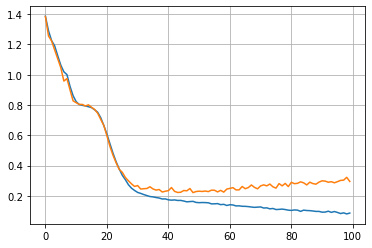

In [12]:
# Loss function - MSE works best for some reason
# criterion = nn.MSELoss()
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Create the encoder and decoder models
encoder = EncoderRNN(hidden_size=64, input_size=2, num_layers=2, device = 'cuda' if gpu else 'cpu')
decoder = DecoderRNN(hidden_size=64, input_size=4, num_layers=2, device = 'cuda' if gpu else 'cpu')

# Initialize the optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), weight_decay=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), weight_decay=0.001)

# Define empty lists where loss progress will be stored
losses, val_losses = [], []

best_loss = np.inf

# Training loop
for _ in range(30):
    train_loss = 0
    for x_train,y_train in train_dataloader:
        
        train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                 teacher_forcing=False, gpu=gpu)

    losses.append(train_loss/len(train_dataloader))
        
    with torch.no_grad():
        val_loss = 0
        for x_val,y_val in val_dataloader:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses.append(val_loss/len(val_dataloader))
        
        # Save only best performing model on validation loss
        if val_losses[-1] < best_loss:
            encoder_weights = encoder.state_dict()
            decoder_weights = decoder.state_dict()
            best_loss = val_losses[-1]
            print(f'best loss: {best_loss}, saving...')
            
encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)
        
plt.plot(losses)
plt.plot(val_losses)
plt.grid()

## Evaluate the model

Define a simple evaluation function. Don't forget to load the models back into main memory from cuda.

In [13]:
def evaluate(x_test, y_test, encoder, decoder):
    
    seq_length = y_test.shape[0]
    batch_size = y_test.shape[1]
    
    encoder_hidden = encoder.initHidden()

    encoder_hidden = encoder.initHidden(batch_size=batch_size)
    _, encoder_hidden = encoder(x_test, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,decoder.input_size))
    decoder_input = torch.zeros((1,batch_size,decoder.input_size))
    for i in range(y_test.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y

    num_correct = torch.sum(decoder_outputs.argmax(axis=2) == y_test.squeeze())
    total_symbols = y_test.squeeze().numel()
    
    return num_correct, total_symbols

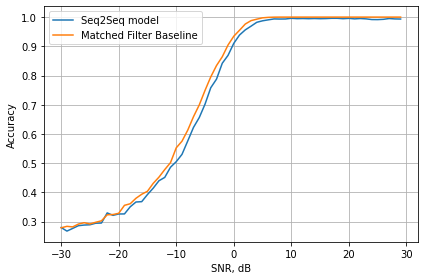

In [14]:
encoder.cpu()
decoder.cpu()

nn_accuracies = []

snr_range = np.arange(-30,30)

for snr in snr_range:

    x, y = gen_data(1024, 5, sps=4, snr=snr)
    x,y = to_tensors(x,y,batch_first=True)

    # create dataset and dataloader
    test_dataset = torch.utils.data.TensorDataset(x, y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

    corrects, totals = 0, 0
    for x,y in test_dataloader:
        x = x.permute((1,0,2))
        y = y.unsqueeze(2).permute((1,0,2))
        correct, total = evaluate(x, y, encoder, decoder)
        corrects += correct
        totals += total

    accuracy = corrects/totals

    nn_accuracies.append(accuracy)
    
plt.plot(snr_range, nn_accuracies)
plt.grid()
plt.plot(snr_range, baseline_accs)
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.legend(('Seq2Seq model', 'Matched Filter Baseline'))
plt.tight_layout()
# plt.savefig('figures/qpsk_demod_accuracy.png', dpi=300)